In [1]:
import math as m
import numpy as np
from IPython.display import clear_output
from time import sleep
from scipy.signal import savgol_filter
import physt
import os
import pandas as pd
from pandas import DataFrame, Series  # for convenience
#from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import pims
import trackpy as tp

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
default_rc = dict(mpl.rcParams)

C:\conda\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [4]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

In [5]:
#change the current working directory to that with data:
str_cwd = r'g:\My Drive\workAppState\prj_shocks\expData\data20230207\soliton_240fps_63-1\analysis\20230304polar\02_an_workFlow_Polar'

In [6]:
os.chdir(str_cwd)

In [7]:
os.chdir(r'./inputs')

In [8]:
os.getcwd()

'g:\\My Drive\\workAppState\\prj_shocks\\expData\\data20230207\\soliton_240fps_63-1\\analysis\\20230304polar\\02_an_workFlow_Polar\\inputs'

In [71]:
#select ROI and range of frames of interest:
curDate=r'20230304' #current date
framesSkip = 1
#define borders of the region of interest
leftBorder = 56.0
rightBorder= 440.0
yMin = 120.0
yMax = 1412.0
r_offset = 250.0
#start and and frames
iBegin = 1
iEnd =  300
dY = 30.0 # width of a bin in the histogram
nB = m.floor((yMax - yMin)/dY)
yBins = np.arange(nB) * dY + yMin + dY/2.0
yBins # bins values for the histogram

array([ 135.,  165.,  195.,  225.,  255.,  285.,  315.,  345.,  375.,
        405.,  435.,  465.,  495.,  525.,  555.,  585.,  615.,  645.,
        675.,  705.,  735.,  765.,  795.,  825.,  855.,  885.,  915.,
        945.,  975., 1005., 1035., 1065., 1095., 1125., 1155., 1185.,
       1215., 1245., 1275., 1305., 1335., 1365., 1395.])

In [10]:
mpl.rc('figure',  figsize=(5, 5.0*1392.0/496.0))
mpl.rc('image', cmap='gray')

In [11]:
frames = pims.open(r'./*.tif')
frames

<Frames>
Source: g:\My Drive\workAppState\prj_shocks\expData\data20230207\soliton_240fps_63-1\analysis\20230304polar\02_an_workFlow_Polar\inputs\*.tif
Length: 300 frames
Frame Shape: (1392, 496)
Pixel Datatype: uint8

In [12]:
type(frames)

pims.image_sequence.ImageSequence

In [13]:
type(frames[0])

pims.frame.Frame

C:\conda\lib\site-packages\matplotlib\patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


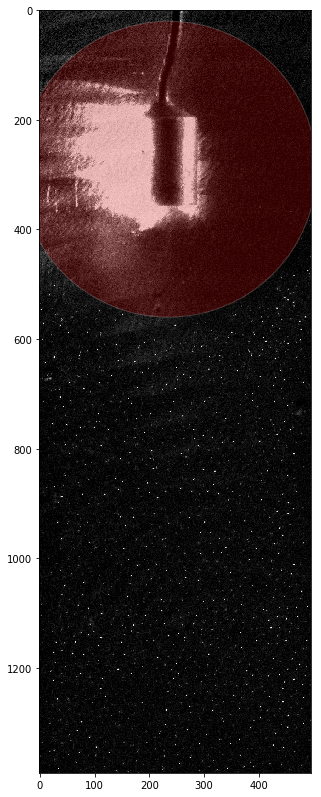

In [14]:
xc = 235
yc = 290
r_sample = 270
fig, ax = plt.subplots()
circle1 = plt.Circle((xc, yc), r_sample, color='r', alpha = 0.2, edgecolor = 'w')
circle1.set_edgecolor('w')
ax.add_patch(circle1)
ax = plt.imshow(frames[180])

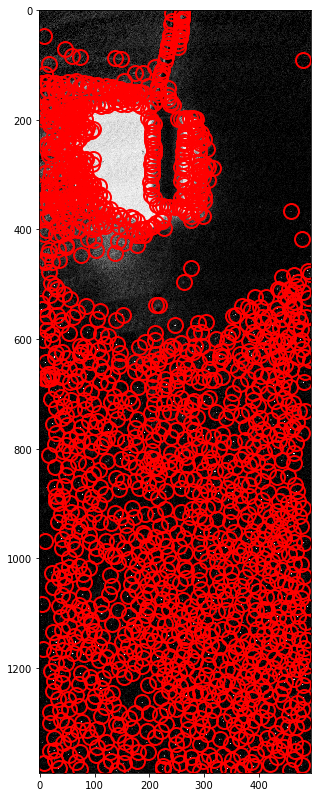

In [15]:
f = tp.locate(frames[180], 7, minmass = 120, separation = 2, threshold = 7)
tp.annotate(f, frames[180])

In [16]:
f_all = tp.batch(frames[:], 7, minmass = 120, separation = 2, threshold = 7)

Frame 299: 1941 features


In [17]:
f_all.tail()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
482453,1384.830013,405.375830,255.725794,1.202587,0.362681,47.205691,744.0,2.712675,299
482454,1384.961390,492.094595,175.917611,1.027611,0.288498,38.375850,542.0,-5.714609,299
482455,1387.902834,86.514170,167.766988,1.345257,0.453674,32.262882,672.0,5.718509,299
482456,1387.596774,111.163594,147.390431,1.195229,0.107500,27.508352,555.0,-7.142652,299
482457,1387.665779,124.374168,255.046575,1.236377,0.257322,46.526472,732.0,2.973138,299


In [18]:
# transform coordinates:
df_trans = f_all
df_trans['x'] = df_trans['x'] - float(xc)
df_trans['y'] = df_trans['y'] - float(yc)
df_trans.tail()


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
482453,1094.830013,170.375830,255.725794,1.202587,0.362681,47.205691,744.0,2.712675,299
482454,1094.961390,257.094595,175.917611,1.027611,0.288498,38.375850,542.0,-5.714609,299
482455,1097.902834,-148.485830,167.766988,1.345257,0.453674,32.262882,672.0,5.718509,299
482456,1097.596774,-123.836406,147.390431,1.195229,0.107500,27.508352,555.0,-7.142652,299
482457,1097.665779,-110.625832,255.046575,1.236377,0.257322,46.526472,732.0,2.973138,299


In [19]:
def f_check_limited(x, y, frame, frame_begin, frame_end, left, right, maxY, minY):
    if (x <= right and x >= left and y <= maxY and y >= minY 
        and frame >= frame_begin and frame <= frame_end):
        return True
    else:
        return False
    

In [20]:
#vectorize the function f_check_limited, so can apply to arrays:
f_check_if_ROI = np.vectorize(f_check_limited)

In [21]:
ind = f_check_if_ROI(f_all['x'], f_all['y'], f_all['frame'], iBegin, iEnd, leftBorder, rightBorder, yMax, yMin)

In [22]:
f_test_roi = f_all[((f_all['x'] + f_all['y']) > 200)]

In [23]:
f_ROI = f_all[ind]

In [24]:
mpl.rcParams.update(default_rc)

C:\conda\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\conda\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


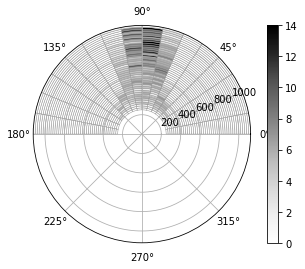

In [72]:
#mpl.rc('figure',  figsize=(6, 4))
#import matplotlib.pyplot as plt
#%matplotlib inline
indf = df_trans['frame'] == 180
df_trans_i = df_trans[indf]
hist = physt.polar(df_trans_i['x'], df_trans_i['y'], phi_range = (0, m.pi), radial_bins = nB, radial_range = (r_offset, yMax - yc))
#fig, ax = plt.subplots()
ax2 = hist.plot.polar_map()



(0, 0.001)

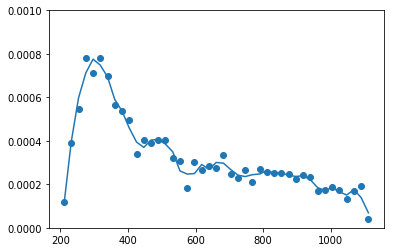

In [81]:
radial = hist.projection("r")
rad_coord = (rad_bins[:,0] + rad_bins[:,1]) / 2.0
fig3, ax3 = plt.subplots()
ax3.scatter(rad_coord, radial.densities)
density_smoothed = savgol_filter(radial.densities, 5, 2)
ax3.plot(rad_coord, density_smoothed)
ax3.set_ylim(0, 0.001)

In [103]:
os.chdir(r'../outputs')

In [97]:
i = 15
m_str = f'{i:05d}'
print(m_str)

00015


frame  1
frame  11
frame  21
frame  31
frame  41
frame  51
frame  61
frame  71
frame  81
frame  91
frame  101
frame  111
frame  121
frame  131
frame  141
frame  151
frame  161
frame  171
frame  181
frame  191
frame  201


C:\conda\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


frame  211
frame  221
frame  231
frame  241
frame  251
frame  261
frame  271
frame  281
frame  291


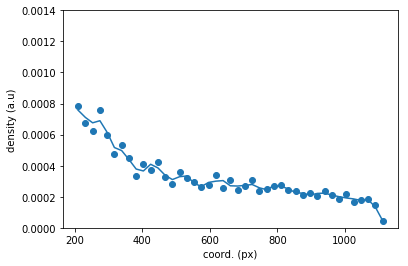

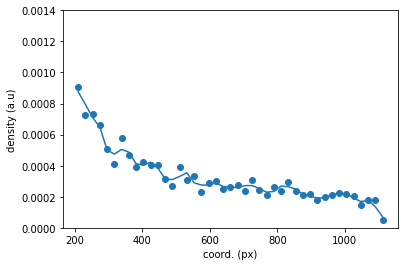

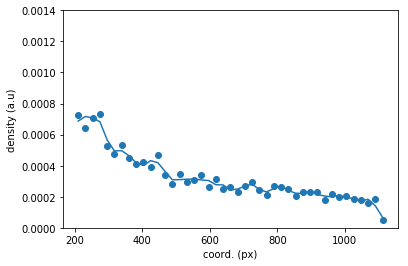

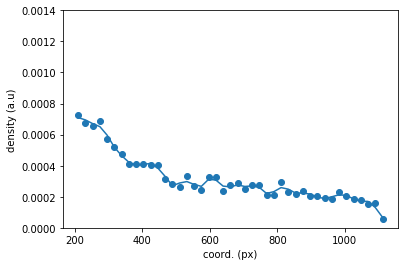

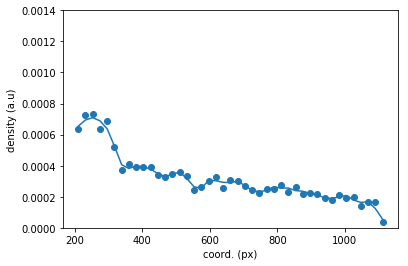

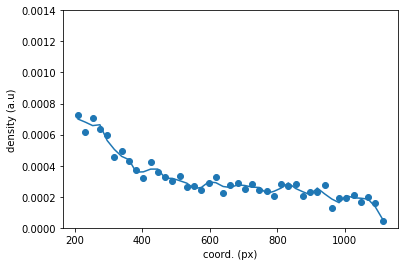

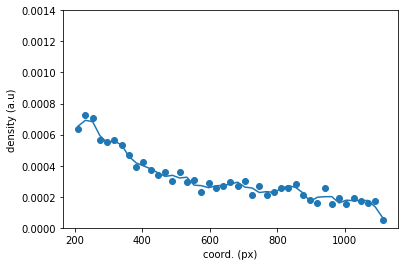

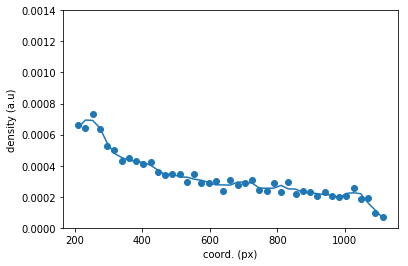

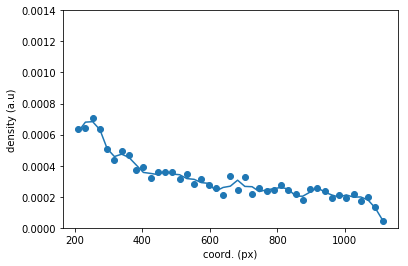

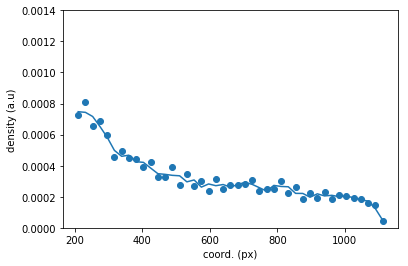

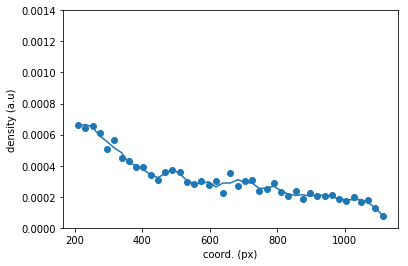

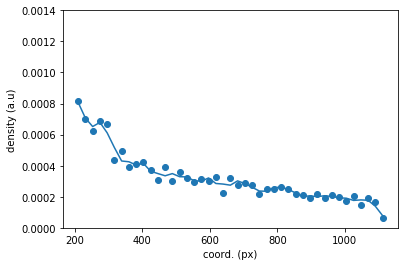

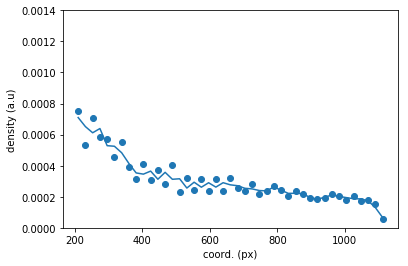

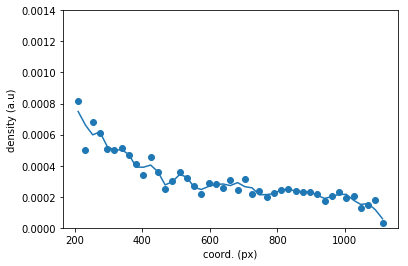

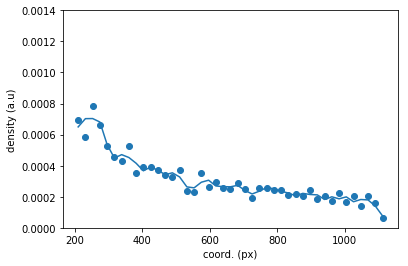

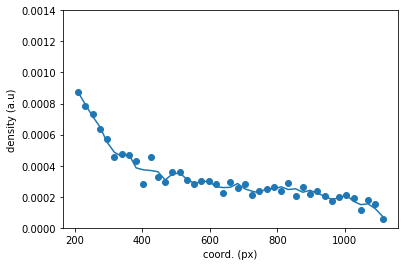

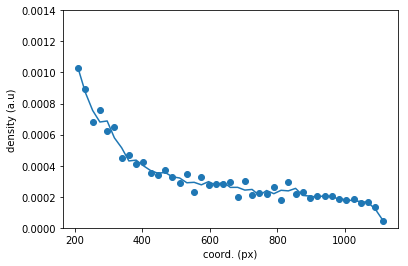

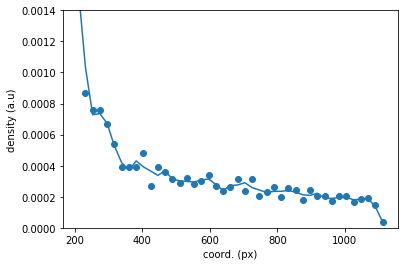

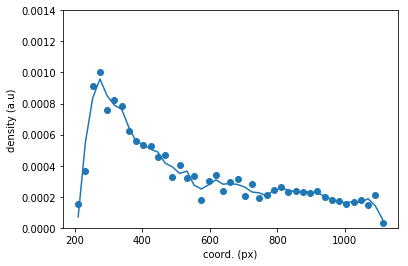

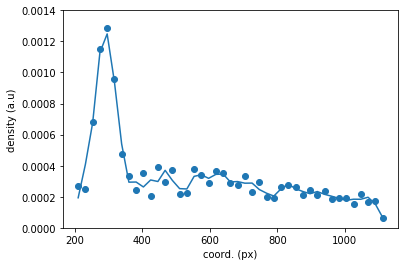

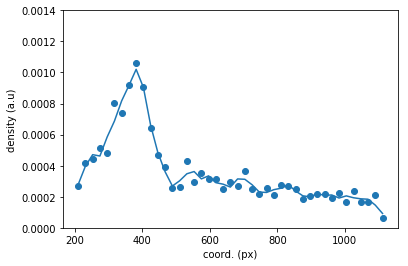

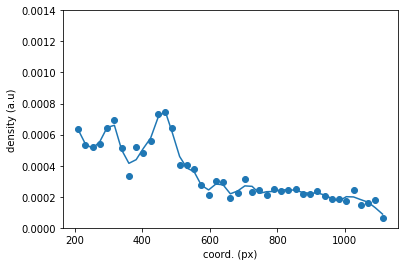

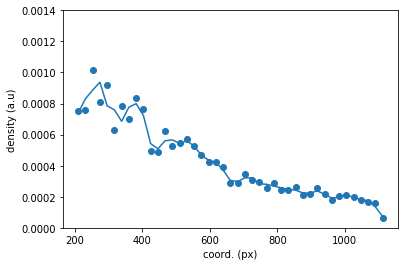

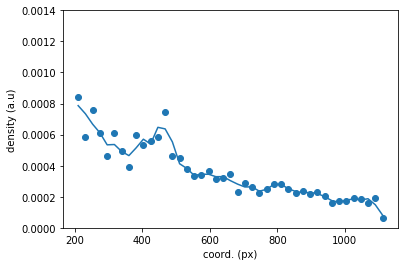

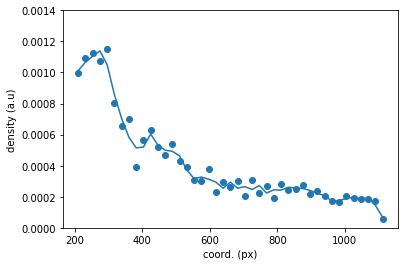

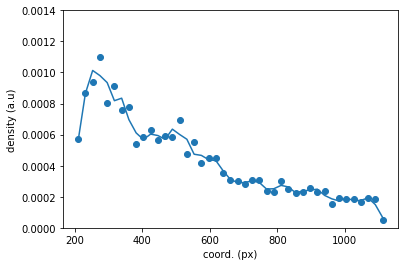

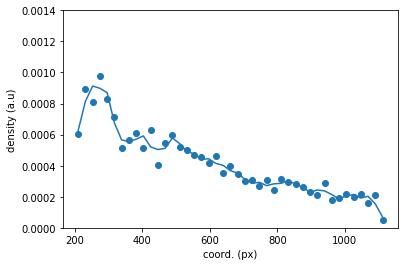

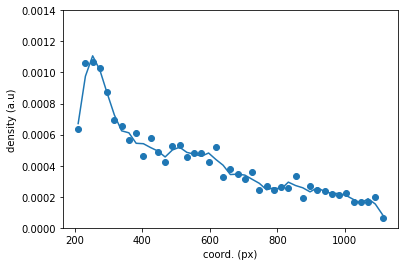

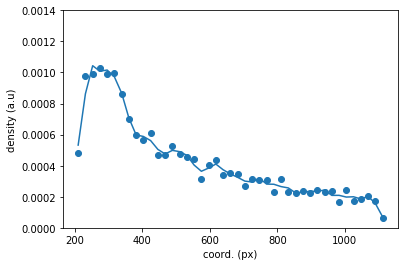

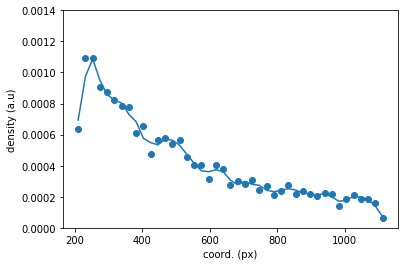

In [106]:
for i in range(iBegin, iEnd, 10):
    print('frame ', i)
    #building histogram using cloud-in-cell (cic):
    indf = df_trans['frame'] == i
    df_trans_i = df_trans[indf]
    hist = physt.polar(df_trans_i['x'], df_trans_i['y'], phi_range = (0, m.pi), radial_bins = nB, radial_range = (r_offset, yMax - yc))
    radial = hist.projection("r")
    rad_coord = (rad_bins[:,0] + rad_bins[:,1]) / 2.0
    fig4, ax4 = plt.subplots()
    ax4.scatter(rad_coord, radial.densities)
    density_smoothed = savgol_filter(radial.densities, 5, 2)
    ax4.plot(rad_coord, density_smoothed)
    ax4.set_ylim(0, 0.0014)
    ax4.set_ylabel('density (a.u)')
    ax4.set_xlabel('coord. (px)')
    str_fig_fname = 'f_' + f'{i:05d}' + '.png'
    fig4.savefig(str_fig_fname)
    
    
    
    

In [ ]:
indf = f_ROI['frame'] == 233
f_ROI_i = f_ROI[indf]
counts, bins = np.histogram(f_ROI_i['y'], nB)
counts = np.array(counts, dtype = np.double)
YforHist = 0.5 * (bins[1:] + bins[:-1])
f1, ax1 = plt.subplots()
print(counts)
ax1.scatter(YforHist, counts)



In [ ]:
counts_smoothed = savgol_filter(counts, 5, 2)

In [ ]:
ax1.plot(YforHist, counts_smoothed)
f1

In [ ]:
x = np.array([2, 2, 5, 2, 1, 0, 1, 4, 9])

In [ ]:
savgol_filter(x, 5, 2)

In [ ]:
type(counts)

In [ ]:
type(x)

In [ ]:
counts

In [ ]:
x